In [1]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator

### From James Original Code, Loads and Preprocess Signal Data From File

<Axes: title={'center': 'Polarization Over Time'}, xlabel='Datetime', ylabel='Polarization'>

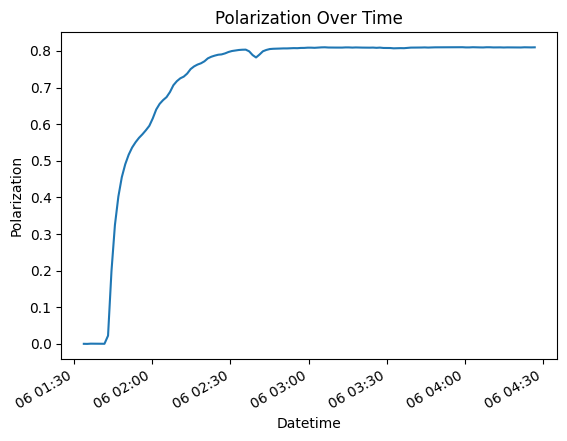

In [25]:
with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

# Plot the polarization over time
df['pol'].plot(title='Polarization Over Time',
                      xlabel='Datetime',
                      ylabel='Polarization')

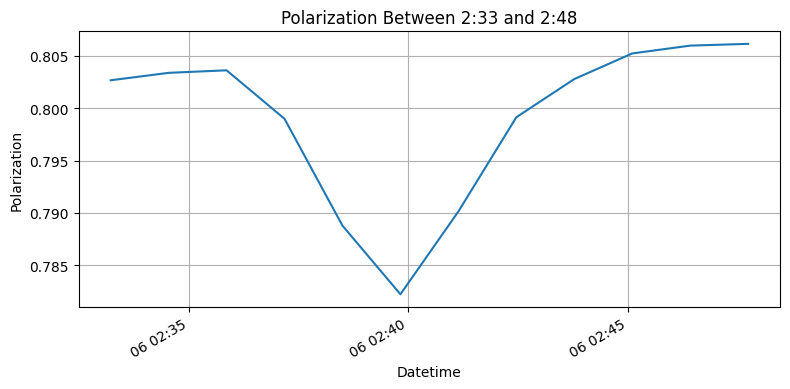

In [31]:
# Define the start and end of the desired time window
start_time = pd.to_datetime("2022-11-06 02:33:00").tz_localize("UTC")
end_time = pd.to_datetime("2022-11-06 02:48:00").tz_localize("UTC")

# Filter DataFrame to the time range
df_filtered = df.loc[start_time:end_time]

# Plot the polarization over the selected time window
df_filtered['pol'].plot(title='Polarization Between 2:33 and 2:48',
                        xlabel='Datetime',
                        ylabel='Polarization',
                        figsize=(8, 4),
                        grid=True)
plt.tight_layout()
plt.show()

In [3]:
df.head

<bound method NDFrame.head of                                    num  \
stop_time                                
2022-11-06 01:33:44.073311+00:00  4000   
2022-11-06 01:35:03.293235+00:00  4000   
2022-11-06 01:36:22.513498+00:00  4000   
2022-11-06 01:37:41.729688+00:00  4000   
2022-11-06 01:39:00.949576+00:00  4000   
...                                ...   
2022-11-06 04:21:29.677975+00:00  4000   
2022-11-06 04:22:48.898293+00:00  4000   
2022-11-06 04:24:08.116986+00:00  4000   
2022-11-06 04:25:27.340763+00:00  4000   
2022-11-06 04:26:46.565984+00:00  4000   

                                                                          freq_list  \
stop_time                                                                             
2022-11-06 01:33:44.073311+00:00  [212.482, 212.48357470703127, 212.485137207031...   
2022-11-06 01:35:03.293235+00:00  [212.482, 212.48357470703127, 212.485137207031...   
2022-11-06 01:36:22.513498+00:00  [212.482, 212.48357470703127, 212.4851372

### Create All Empty Lists

In [4]:
# Store fit results
fit_results = []

# Store area results
area_results = []

# Make Time_steps list
time = df['pol'].index

# Create lists for Gaussian Variables
amp1_list, amp2_list, amp3_list = [], [], []
cen1_list, cen2_list, cen3_list = [], [], []
wid1_list, wid2_list, wid3_list = [], [], []

amp1_error, amp2_error, amp3_error = [], [], []
cen1_error, cen2_error, cen3_error = [], [], []
wid1_error, wid2_error, wid3_error = [], [], []


### Define Gaussian(s)

In [5]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

### Fit and Plot Individual Curve

In [6]:
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        # Fit and get covariance matrix
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        # Print parameters and uncertainties
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            amp_error, cen_error, wid_error = perr[i*3:i*3+3]
            print(f"Gaussian {i+1}:")
            print(f"Amplitude = {amp:.4f} ± {amp_error:.4f}")
            print(f"Center    = {cen:.2f} ± {cen_error:.2f}")
            print(f"Width     = {wid:.2f} ± {wid_error:.2f}")

        # Append results
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })

        # Plot original and fit
        plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
        plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

        # Plot individual Gaussians
        colors = ['tab:blue', 'tab:orange', 'tab:green']
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            g = gaussian(x_data, amp, cen, wid)
            label = f'Gaussian{i+1}'
            plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

        plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")

# Create Slider

In [7]:
interact(plot_pol_array_with_fit,
         index=IntSlider(min=8, max=len(df)-1, step=1, value=9, description='Row Index:'))

interactive(children=(IntSlider(value=9, description='Row Index:', max=131, min=8), Output()), _dom_classes=('…

<function __main__.plot_pol_array_with_fit(index)>

### Curve Fitting for the Plots

In [8]:
# Setting upper and lower bounds to the fit
lowbound = (-np.inf, -np.inf, 0, -np.inf, -np.inf, 0, -np.inf, -np.inf, 0)
upbound = (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf,)

#  Curve Fitting!
for i in range(len(df)):
    
    signal_array = df.iloc[i]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, bounds=(lowbound, upbound), maxfev=10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        model = three_gaussians(x_data, *popt)
        residuals = signal_array - model
        sigma = np.std(residuals, ddof=1)

        if sigma <= 0 or np.isnan(sigma):
            continue  # Skip unreliable fits

        chi2 = np.sum((residuals / sigma) ** 2)
        dof = len(signal_array) - len(popt)
        reduced_chi2 = chi2 / dof

        fit_results.append({
            'index': i,
            'time': df.index[i],
            'pol': df.iloc[i]['pol'],
            'params': popt,
            'errors': perr,
            'chi2': chi2,
            'reduced_chi2': reduced_chi2
    })
    except RuntimeError:
        continue

# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

### Areas Under the Gaussian Curves

In [9]:
# Iterate through each fit result
for i, row in fit_df.iterrows():
    # Check if 'params' pr 'errors' is NaN or failed fit
    if not isinstance(row['params'], (list, np.ndarray)) or not isinstance(row['errors'], (list, np.ndarray)):
        area_results.append({'time': row['time'], 'total_area': np.nan, 'total_area_error': np.nan})
        continue

    # Store sum of gaussian areas and total variance (for error propagation)
    total_area = 0
    total_var = 0

    for j in range(3):
        amp = row['params'][j * 3]          # Amplitude
        wid = row['params'][j * 3 + 2]      # Width
        amp_err = row['errors'][j * 3]      # Amplitude Error
        wid_err = row['errors'][j * 3 + 2]  # Width Error

        # Calculate Area
        area = (amp * wid) / 0.3989

        # Error propagation
        area_error = area * np.sqrt((amp_err / amp)**2 + (wid_err / wid)**2) if amp != 0 and wid != 0 else np.nan

        # Add area and vairance values to the totals 
        total_area += area
        total_var += area_error**2 if not np.isnan(area_error) else 0

    # Store the area results to the list
    area_results.append({
        'time': row['time'],
        'total_area': total_area,
        'total_area_error': np.sqrt(total_var)
    })

# Convert to DataFrame for plotting
area_df = pd.DataFrame(area_results)



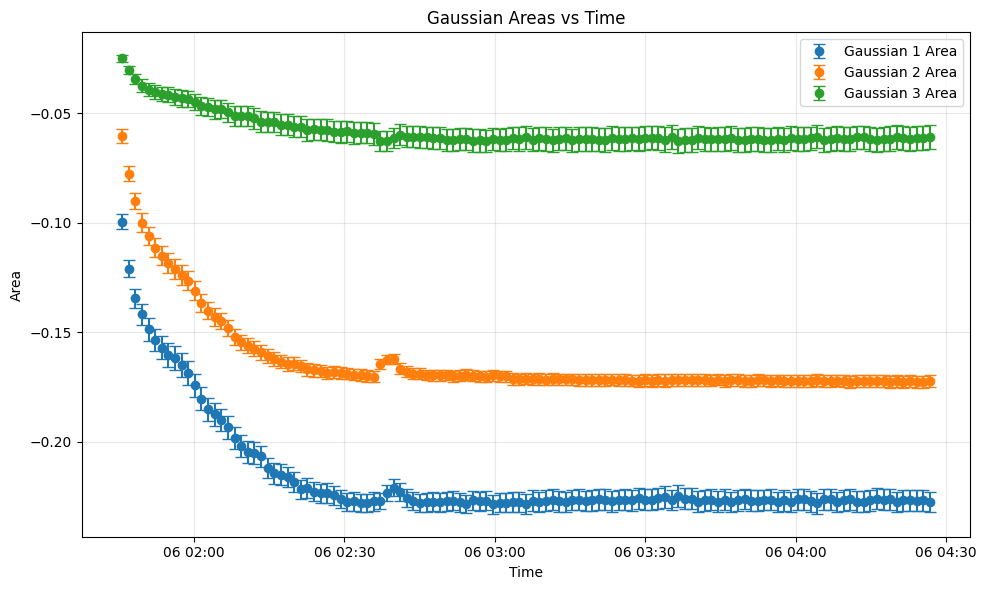

In [10]:
# Filter fit_df to only include data after 1:45
start_time = pd.to_datetime("2022-11-06 01:45:00").tz_localize("UTC")
fit_df_late = fit_df[fit_df['time'] >= start_time]

plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for j in range(3):
    # Calculate the areas of each row
    areas = fit_df_late.apply(
        lambda row: (row['params'][j * 3] * row['params'][j * 3 + 2]) / 0.3989
        if isinstance(row['params'], (list, np.ndarray)) else np.nan,
        axis=1
    )

    # Calculate errors for each row and check if valid
    area_errors = fit_df_late.apply(
        lambda row: abs(
            (row['params'][j * 3] * row['params'][j * 3 + 2]) / 0.3989 *
            np.sqrt(
                (row['errors'][j * 3] / row['params'][j * 3])**2 +
                (row['errors'][j * 3 + 2] / row['params'][j * 3 + 2])**2
            )
        ) if (
            isinstance(row['params'], (list, np.ndarray)) and
            isinstance(row['errors'], (list, np.ndarray)) and
            row['params'][j * 3] != 0 and
            row['params'][j * 3 + 2] != 0 and
            row['errors'][j * 3] > 0 and
            row['errors'][j * 3 + 2] > 0
        ) else np.nan,
        axis=1
    )

    # Filters out extreme (inf) values
    mask = (
        areas.notna() &
        area_errors.notna() &
        (area_errors < 0.5) &       # Rids of large error bars
        (~np.isinf(area_errors)) &
        (~np.isinf(areas))
    )

    # Plot area with error bars
    plt.errorbar(
        fit_df_late['time'][mask], areas[mask], yerr=area_errors[mask],
        fmt='o', capsize=4, label=f'Gaussian {j+1} Area', color=colors[j]
    )

# Plot
plt.xlabel("Time")
plt.ylabel("Area")
plt.title("Gaussian Areas vs Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



### $\chi^2$ and Reduced $\chi^2$

In [11]:
print(fit_df[['time', 'chi2']])
print(fit_df[['time', 'reduced_chi2']])

                                time        chi2
0   2022-11-06 01:45:40.166998+00:00         NaN
1   2022-11-06 01:33:44.073311+00:00  511.002033
2   2022-11-06 01:35:03.293235+00:00  511.000001
3   2022-11-06 01:36:22.513498+00:00  511.002607
4   2022-11-06 01:37:41.729688+00:00  511.019666
..                               ...         ...
128 2022-11-06 04:21:29.677975+00:00  511.500279
129 2022-11-06 04:22:48.898293+00:00  511.619890
130 2022-11-06 04:24:08.116986+00:00  511.633572
131 2022-11-06 04:25:27.340763+00:00  511.562108
132 2022-11-06 04:26:46.565984+00:00  511.578645

[133 rows x 2 columns]
                                time  reduced_chi2
0   2022-11-06 01:45:40.166998+00:00           NaN
1   2022-11-06 01:33:44.073311+00:00      1.015909
2   2022-11-06 01:35:03.293235+00:00      1.015905
3   2022-11-06 01:36:22.513498+00:00      1.015910
4   2022-11-06 01:37:41.729688+00:00      1.015944
..                               ...           ...
128 2022-11-06 04:21:29.677975+

### Create Plot of Amplitudes vs Time

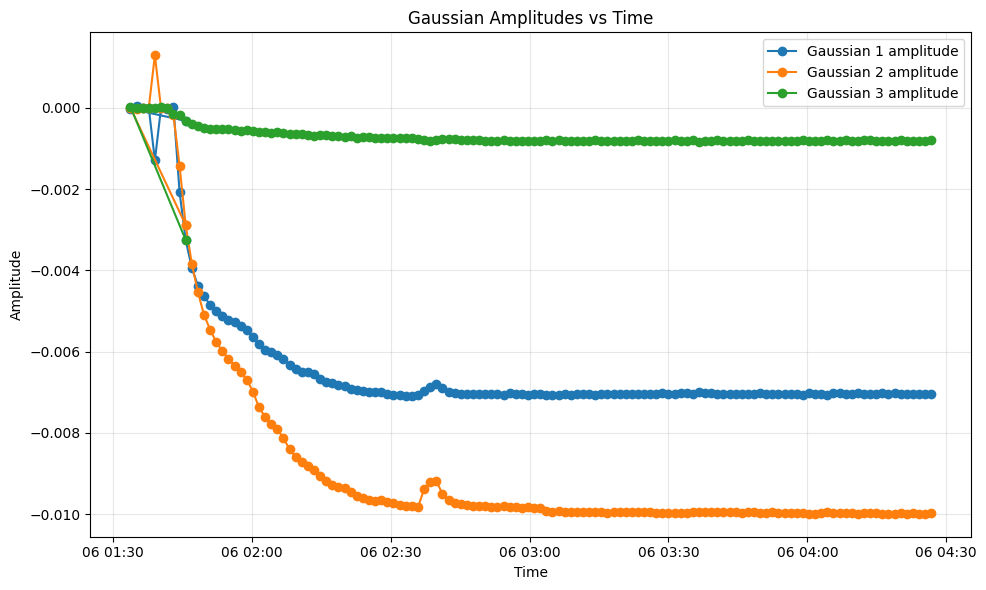

In [12]:
plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_error, cen_error, wid_error = perr[i*3:i*3+3]
    plt.plot(fit_df['time'], amps, 'o-', label=f'Gaussian {i+1} amplitude')
    
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Gaussian Amplitudes vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Plot of Centers vs Time

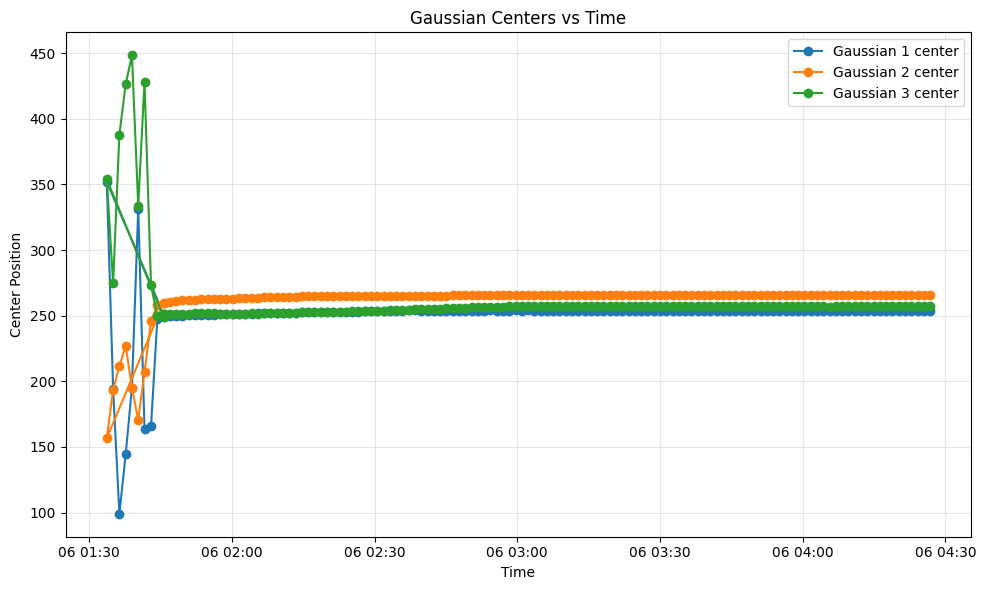

In [13]:
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3+1] if isinstance(p, (list, np.ndarray)) else np.nan)
    plt.plot(fit_df['time'], centers, 'o-', label=f'Gaussian {i+1} center')

plt.xlabel('Time')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Plot of Widths vs Time

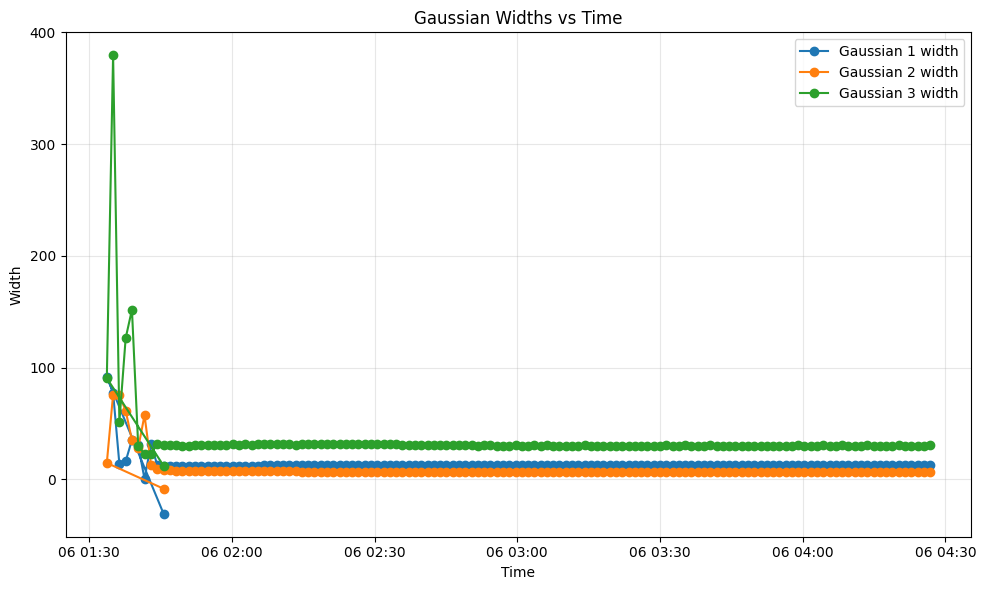

In [14]:
plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df['params'].apply(lambda p: p[i*3+2] if isinstance(p, (list, np.ndarray)) else np.nan)
    plt.plot(fit_df['time'], widths, 'o-', label=f'Gaussian {i+1} width')

plt.xlabel('Time')
plt.ylabel('Width')
plt.title('Gaussian Widths vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Amplitudes vs Time Plot (with Error Bars)

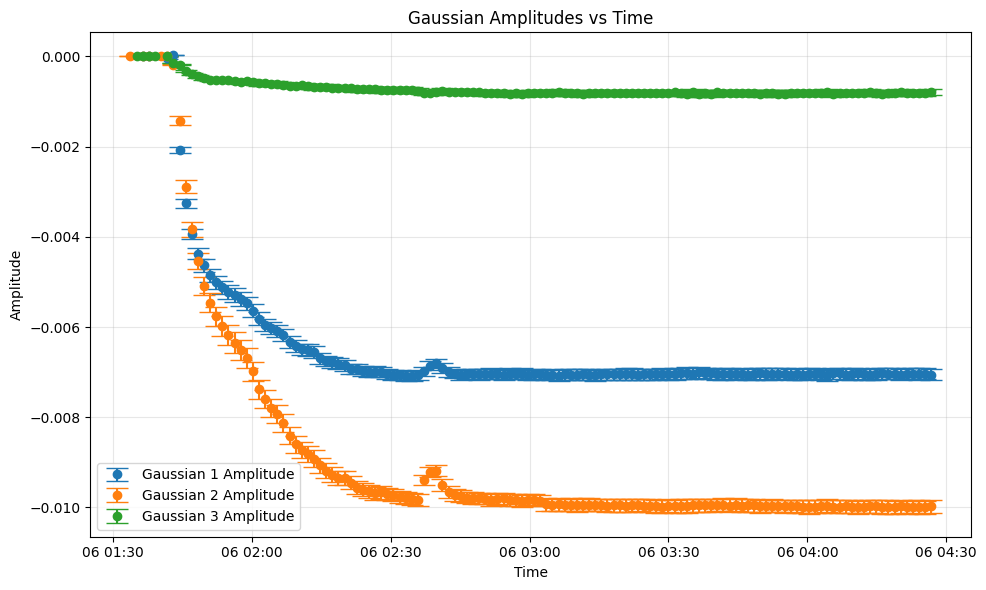

In [15]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_errors = fit_df['errors'].apply(lambda e: e[i*3] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (amp_errors < 0.005) & (~np.isnan(amp_errors)) & (~np.isinf(amp_errors))
    filtered_amps = amps.where(mask, np.nan)
    filtered_errors = amp_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_amps, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Amplitude', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Create Centers vs Time Plot (with Error Bars)

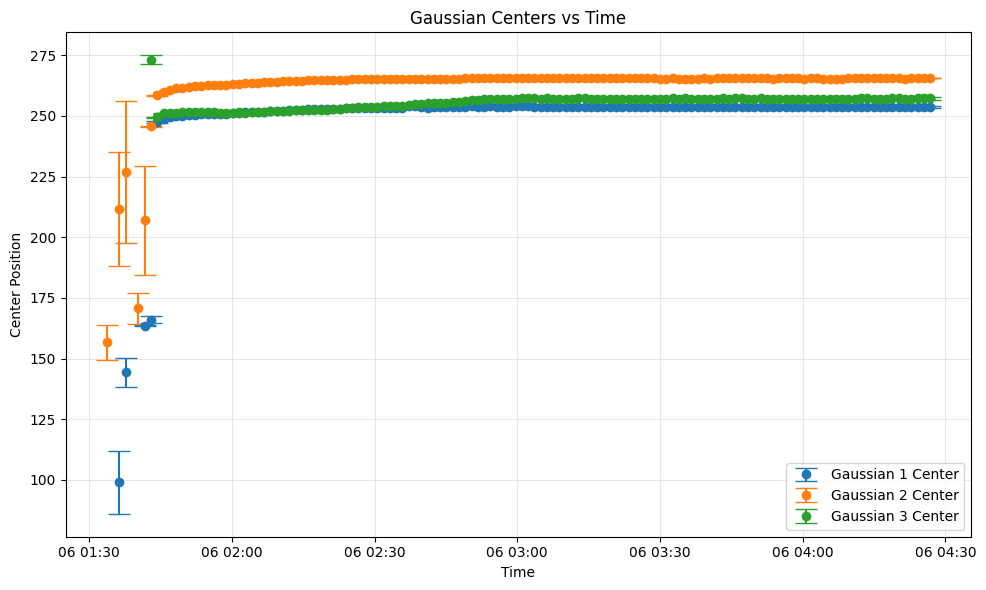

In [16]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3 + 1] if isinstance(p, (list, np.ndarray)) else np.nan)
    center_errors = fit_df['errors'].apply(lambda e: e[i*3 + 1] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (centers < 300) & (center_errors < 300) & (~np.isnan(center_errors)) & (~np.isinf(center_errors))
    filtered_centers = centers.where(mask, np.nan)
    filtered_errors = center_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_centers, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Center', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Center Position")
plt.title("Gaussian Centers vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Create Widths vs Time Plot (with Error Bars)

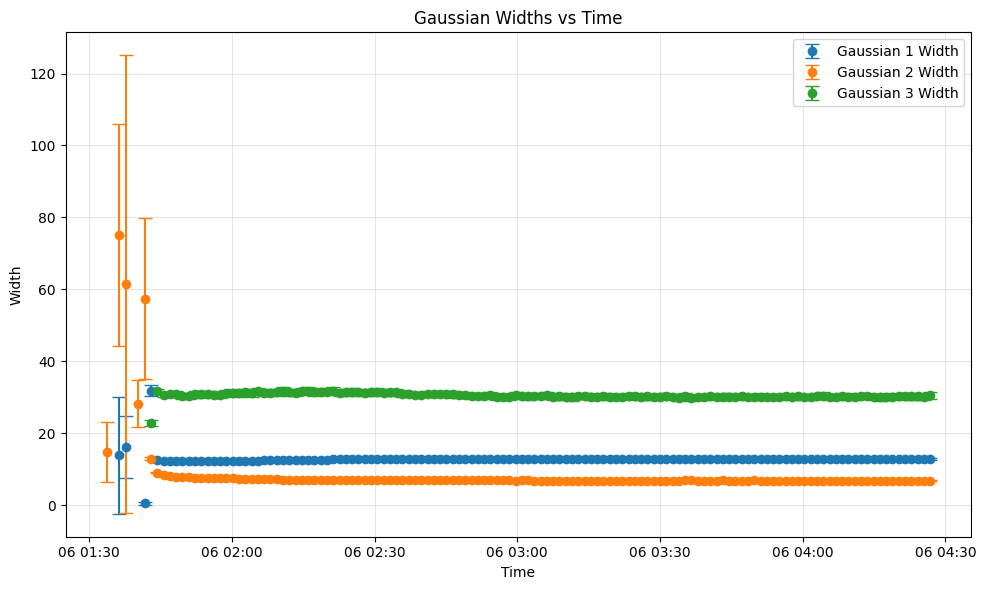

In [17]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df['params'].apply(lambda p: p[i*3 + 2] if isinstance(p, (list, np.ndarray)) else np.nan)
    width_errors = fit_df['errors'].apply(lambda e: e[i*3 + 2] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (width_errors < 200) & (~np.isnan(width_errors)) & (~np.isinf(width_errors))
    filtered_widths = widths.where(mask, np.nan)
    filtered_errors = width_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_widths, yerr=filtered_errors,
        fmt='o', capsize=5, label=f'Gaussian {i+1} Width', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Width")
plt.title("Gaussian Widths vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

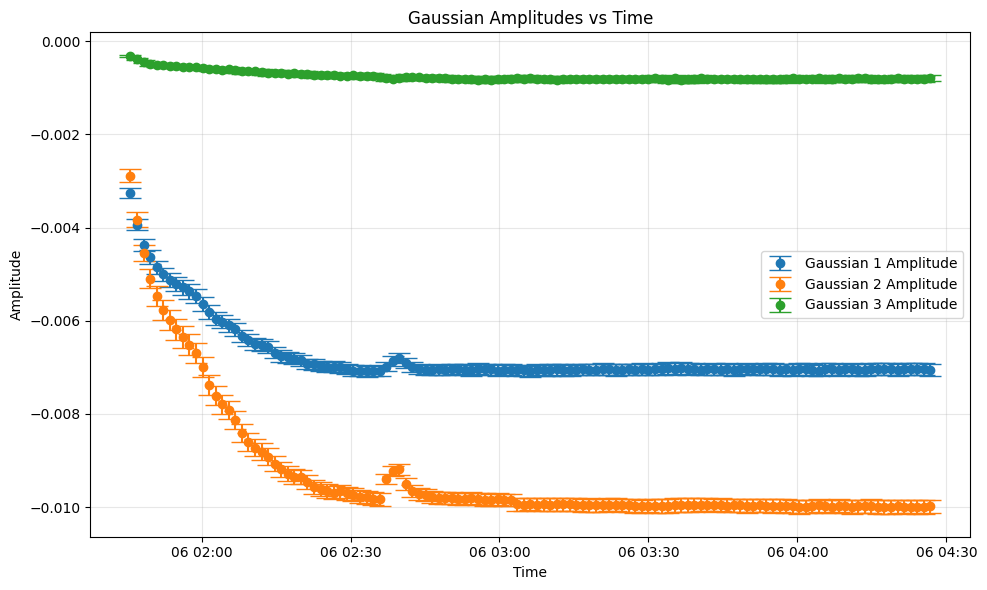

In [18]:
# Filter fit_df to only include data after 1:45
start_time = pd.to_datetime("2022-11-06 01:45:00").tz_localize("UTC")
fit_df_late = fit_df[fit_df['time'] >= start_time]

# Amplitude Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df_late['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_errors = fit_df_late['errors'].apply(lambda e: e[i*3] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (amp_errors < 0.005) & (~np.isnan(amp_errors)) & (~np.isinf(amp_errors))
    filtered_amps = amps.where(mask, np.nan)
    filtered_errors = amp_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_amps, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Amplitude', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


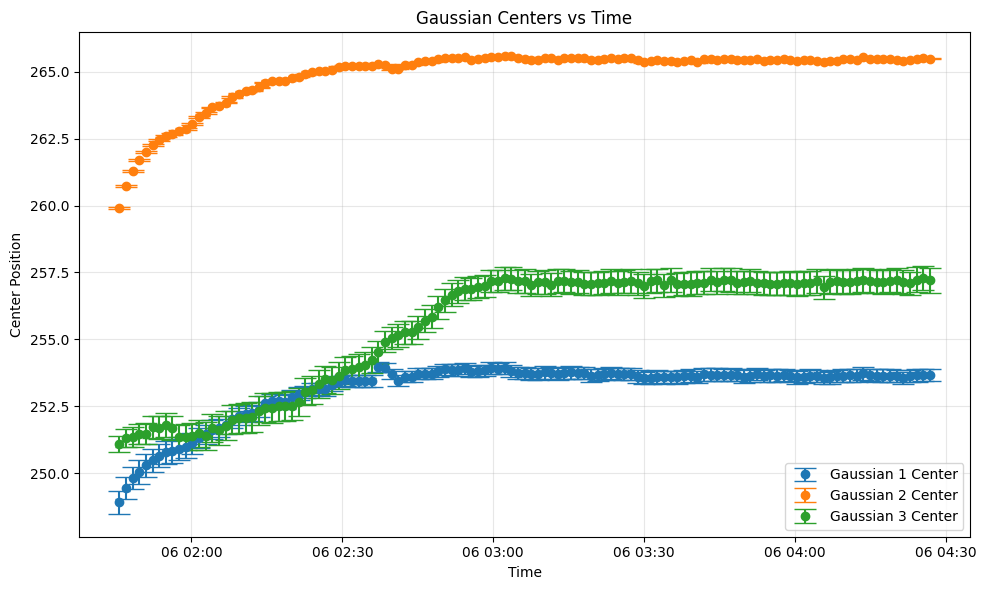

In [19]:
# Center Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df_late['params'].apply(lambda p: p[i*3 + 1] if isinstance(p, (list, np.ndarray)) else np.nan)
    center_errors = fit_df_late['errors'].apply(lambda e: e[i*3 + 1] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (centers < 300) & (center_errors < 300) & (~np.isnan(center_errors)) & (~np.isinf(center_errors))
    filtered_centers = centers.where(mask, np.nan)
    filtered_errors = center_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_centers, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Center', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Center Position")
plt.title("Gaussian Centers vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


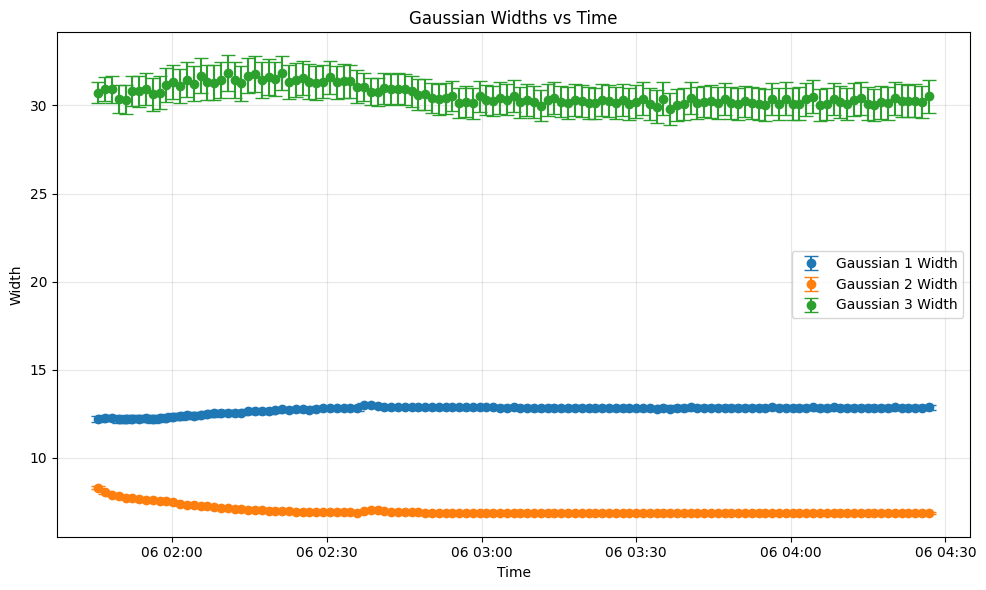

In [20]:
# Width Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df_late['params'].apply(lambda p: p[i*3 + 2] if isinstance(p, (list, np.ndarray)) else np.nan)
    width_errors = fit_df_late['errors'].apply(lambda e: e[i*3 + 2] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (width_errors < 200) & (~np.isnan(width_errors)) & (~np.isinf(width_errors))
    filtered_widths = widths.where(mask, np.nan)
    filtered_errors = width_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_widths, yerr=filtered_errors,
        fmt='o', capsize=5, label=f'Gaussian {i+1} Width', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Width")
plt.title("Gaussian Widths vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


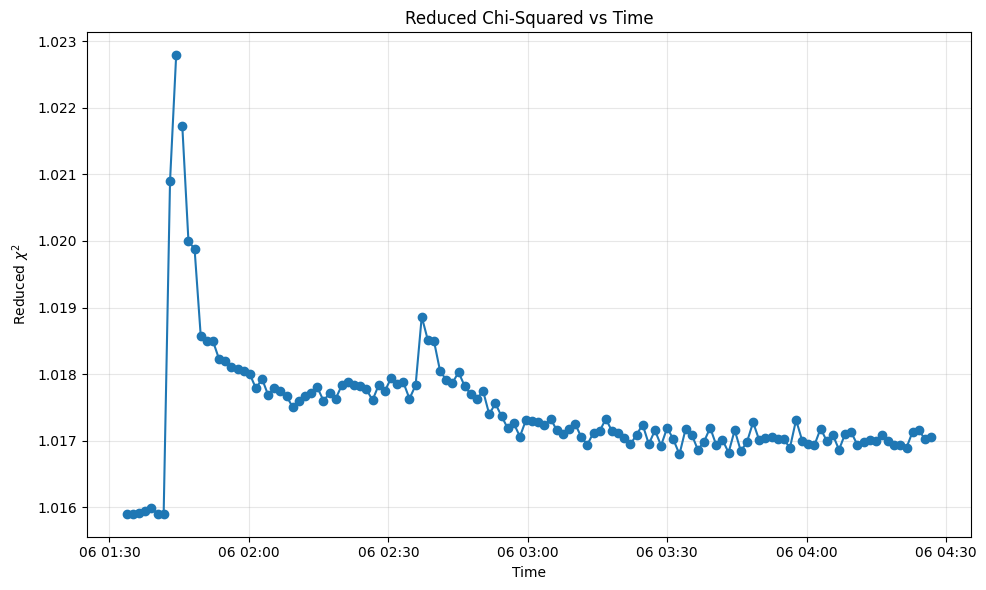

In [21]:
# Sort by time to ensure clean plot
fit_df = fit_df.sort_values(by='time')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fit_df['time'], fit_df['reduced_chi2'], 'o-', color='tab:blue')

plt.xlabel("Time")
plt.ylabel("Reduced $\chi^2$")
plt.title("Reduced Chi-Squared vs Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

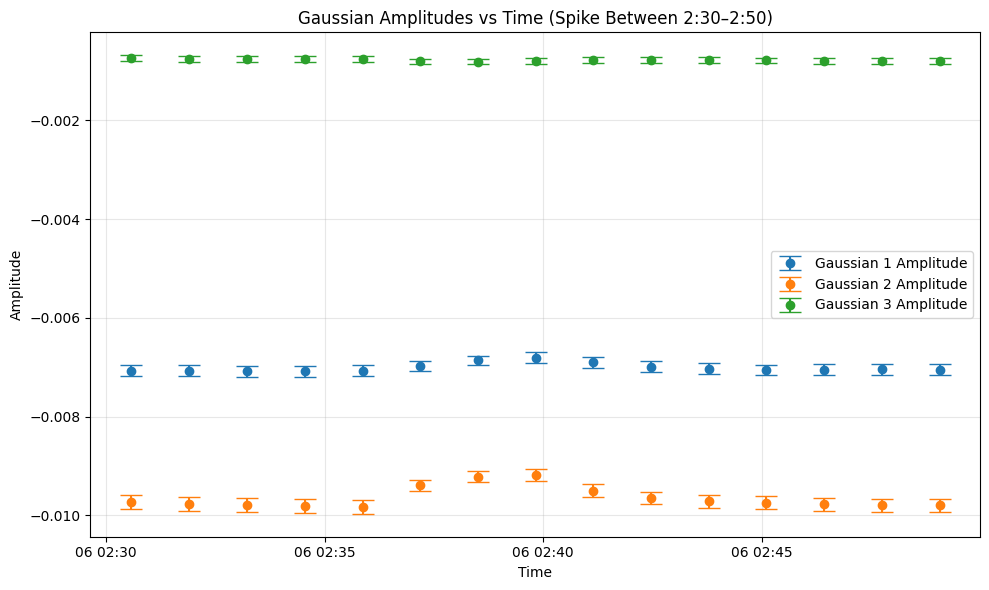

In [22]:
# Filter fit_df to only include data between 2:30 and 2:50
spike_start_time = pd.to_datetime("2022-11-06 02:30").tz_localize("UTC")
spike_end_time = pd.to_datetime("2022-11-06 02:50:00").tz_localize("UTC")
fit_df_spike = fit_df[(fit_df['time'] >= spike_start_time) & (fit_df['time'] <= spike_end_time)]

# Amplitude Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df_spike['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_errors = fit_df_spike['errors'].apply(lambda e: e[i*3] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (amp_errors < 0.005) & (~np.isnan(amp_errors)) & (~np.isinf(amp_errors))
    filtered_amps = amps.where(mask, np.nan)
    filtered_errors = amp_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_spike['time'], filtered_amps, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Amplitude', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time (Spike Between 2:30–2:50)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


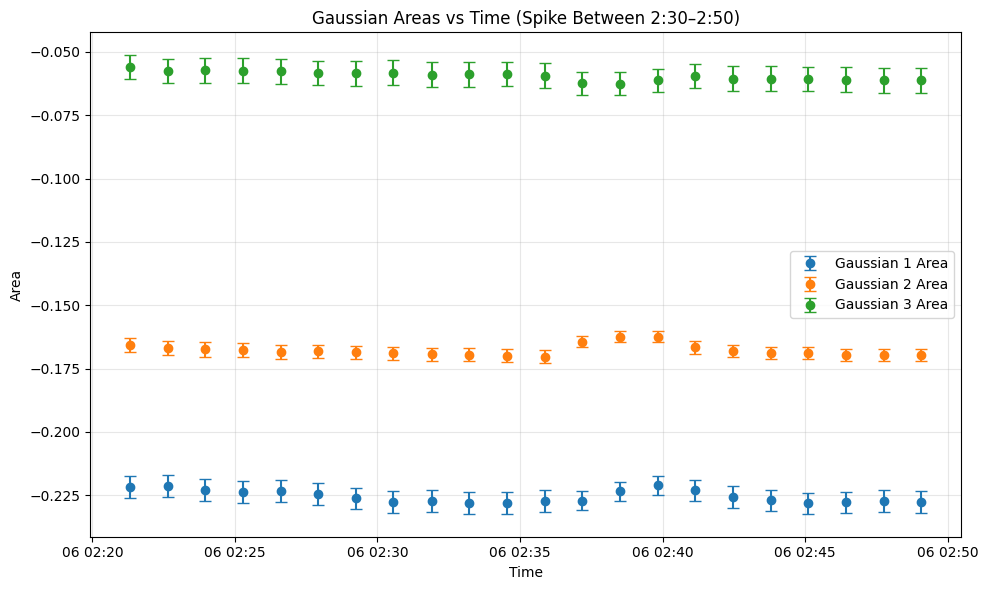

In [23]:
# Filter fit_df to only include data between 2:30 and 2:50
spike_start_time = pd.to_datetime("2022-11-06 02:20").tz_localize("UTC")
spike_end_time = pd.to_datetime("2022-11-06 02:50:00").tz_localize("UTC")
fit_df_spike = fit_df[(fit_df['time'] >= spike_start_time) & (fit_df['time'] <= spike_end_time)]

plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for j in range(3):
    # Calculate the areas of each row
    areas = fit_df_spike.apply(
        lambda row: (row['params'][j * 3] * row['params'][j * 3 + 2]) / 0.3989
        if isinstance(row['params'], (list, np.ndarray)) else np.nan,
        axis=1
    )

    # Calculate errors for each row and check if valid
    area_errors = fit_df_spike.apply(
        lambda row: abs(
            (row['params'][j * 3] * row['params'][j * 3 + 2]) / 0.3989 *
            np.sqrt(
                (row['errors'][j * 3] / row['params'][j * 3])**2 +
                (row['errors'][j * 3 + 2] / row['params'][j * 3 + 2])**2
            )
        ) if (
            isinstance(row['params'], (list, np.ndarray)) and
            isinstance(row['errors'], (list, np.ndarray)) and
            row['params'][j * 3] != 0 and
            row['params'][j * 3 + 2] != 0 and
            row['errors'][j * 3] > 0 and
            row['errors'][j * 3 + 2] > 0
        ) else np.nan,
        axis=1
    )

    # Filters out extreme (inf) values
    mask = (
        areas.notna() &
        area_errors.notna() &
        (area_errors < 0.5) &       # Rids of large error bars
        (~np.isinf(area_errors)) &
        (~np.isinf(areas))
    )

    # Plot area with error bars
    plt.errorbar(
        fit_df_spike['time'][mask], areas[mask], yerr=area_errors[mask],
        fmt='o', capsize=4, label=f'Gaussian {j+1} Area', color=colors[j]
    )

# Plot
plt.xlabel("Time")
plt.ylabel("Area")
plt.title("Gaussian Areas vs Time (Spike Between 2:30–2:50)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

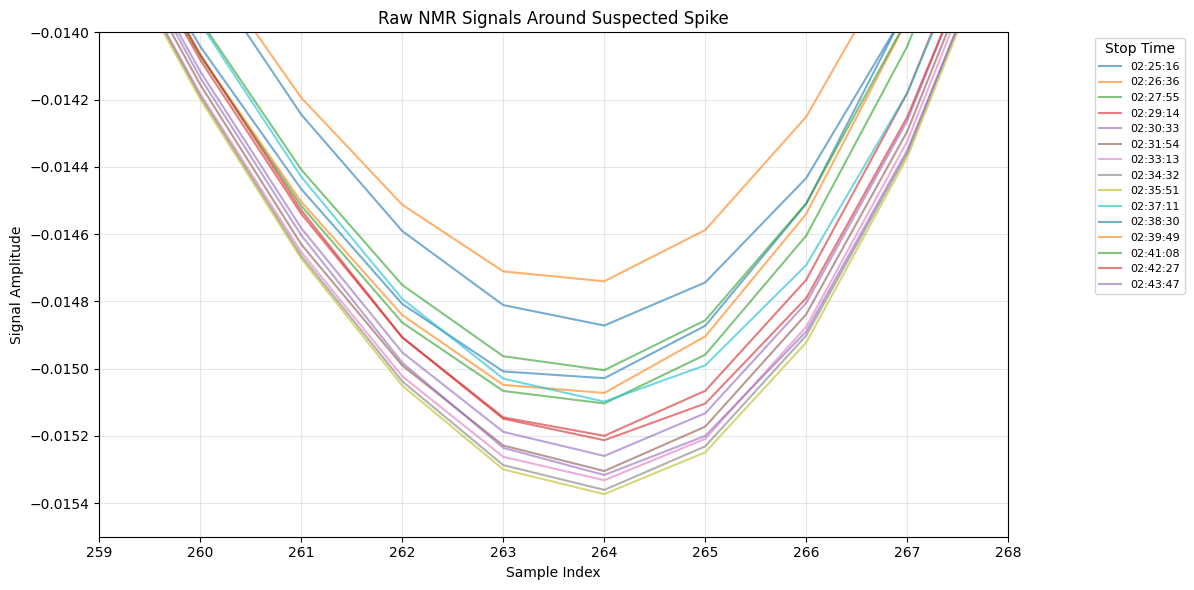

In [55]:
def plot_signals_around_spike(start_str="2022-11-06 02:25:00", end_str="2022-11-06 02:45:00"):
    start_time = pd.to_datetime(start_str).tz_localize("UTC")
    end_time = pd.to_datetime(end_str).tz_localize("UTC")

    df_spike = df[(df.index >= start_time) & (df.index <= end_time)]

    plt.figure(figsize=(12, 6))
    for i, (timestamp, row) in enumerate(df_spike.iterrows()):
        res = row['rescurve']
        if isinstance(res, list):
            x = np.arange(len(res))
            plt.plot(x, res, alpha=0.6, label=timestamp.strftime("%H:%M:%S"))

    plt.title("Raw NMR Signals Around Suspected Spike")
    plt.xlabel("Sample Index")
    plt.ylabel("Signal Amplitude")
    plt.legend(title="Stop Time", fontsize=8, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.xlim(259, 268)
    plt.ylim(-0.01550, -0.014)
    plt.show()


plot_signals_around_spike("2022-11-06 02:25:00", "2022-11-06 02:45:00")

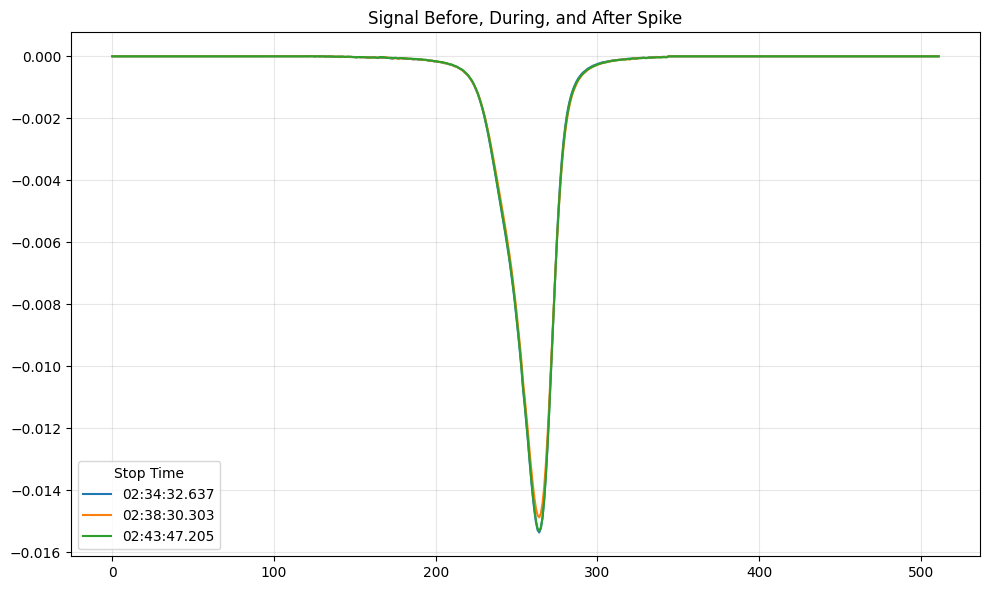

In [63]:
# Define the desired times (as naive times)
target_times = [
    "2022-11-06 02:34:32",
    "2022-11-06 02:38:30",
    "2022-11-06 02:43:47"
]

# Convert to timezone-aware datetime (assuming your df index is in UTC)
target_times = [pd.to_datetime(ts).tz_localize("UTC") for ts in target_times]

plt.figure(figsize=(10, 6))

for ts in target_times:
    # Find the closest time in the DataFrame
    closest_time = df.index.get_indexer([ts], method='nearest')
    matched_time = df.index[closest_time[0]]
    
    res = df.loc[matched_time, 'rescurve']
    if isinstance(res, list):
        x = np.arange(len(res))
        plt.plot(x, res, label=matched_time.strftime('%H:%M:%S.%f')[:-3])

plt.title("Signal Before, During, and After Spike")
#plt.xlabel("Sample Index")
#plt.ylabel("Signal Amplitude")
plt.legend(title="Stop Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

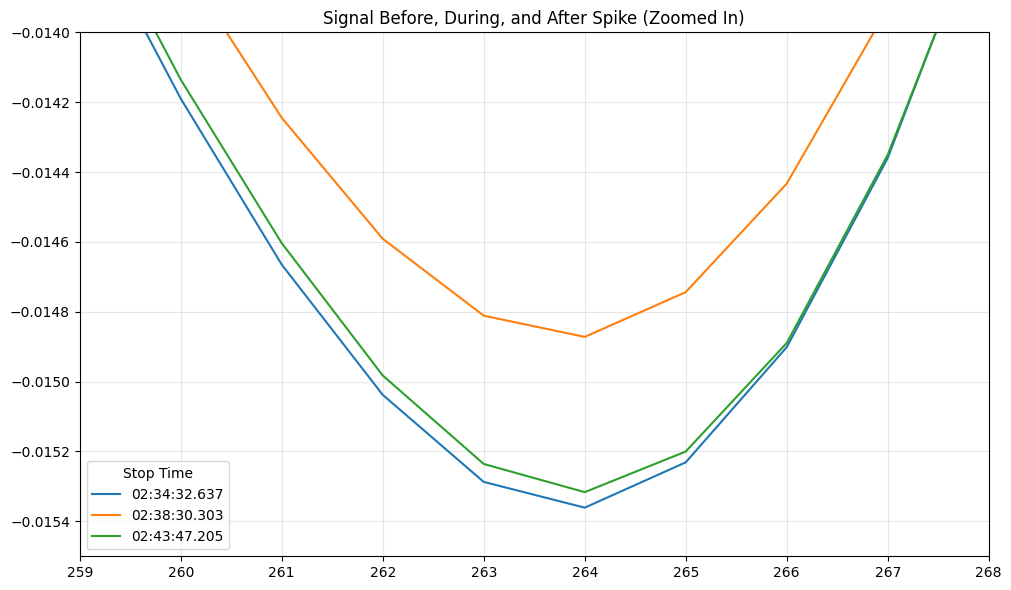

In [65]:
# Define the desired times (as naive times)
target_times = [
    "2022-11-06 02:34:32",
    "2022-11-06 02:38:30",
    "2022-11-06 02:43:47"
]

# Convert to timezone-aware datetime (assuming your df index is in UTC)
target_times = [pd.to_datetime(ts).tz_localize("UTC") for ts in target_times]

plt.figure(figsize=(10, 6))

for ts in target_times:
    # Find the closest time in the DataFrame
    closest_time = df.index.get_indexer([ts], method='nearest')
    matched_time = df.index[closest_time[0]]
    
    res = df.loc[matched_time, 'rescurve']
    if isinstance(res, list):
        x = np.arange(len(res))
        plt.plot(x, res, label=matched_time.strftime('%H:%M:%S.%f')[:-3])

plt.title("Signal Before, During, and After Spike (Zoomed In)")
#plt.xlabel("Sample Index")
#plt.ylabel("Signal Amplitude")
plt.legend(title="Stop Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xlim(259, 268)
plt.ylim(-0.01550, -0.014)
plt.show()